In [1]:
import numpy as np
import h5py
import glob
from os.path import *

from unet import bcgunet
from bigru import bcgbigru
from transfomers import bcgtransfomers

ffs = glob.glob('data/noscan/170327_PYL/analysis/eyeclose_*.mat')
result_obs = []
result_unet = []
result_bigru = []
result_transformers = []
result_eeg = []

for close_f in ffs:  

    # ECG data import
    open_f = close_f.replace('close', 'open')
    if not isfile(open_f) or "bcgnet" in close_f:
        continue


    # ECG eye close data
    f = h5py.File(close_f , 'r')
    ECG = np.array(f['ECG']).flatten()
    EEG = np.array(f['EEG_before_bcg']).T
    EEG_OBS = np.array(f['EEG']).T
    
    print("unet")
    EEG_unet = bcgunet.run(EEG, ECG, iter_num=500)
    print("gru")
    EEG_bigru = bcgbigru.run(EEG, ECG, iter_num=500)
    print("transformer")
    EEG_transformers = bcgtransfomers.run(EEG, ECG, iter_num=500)

    psd_obs_close = bcgunet.get_psd(EEG_OBS[:, ::10], sfreq=500)
    psd_unet_close = bcgunet.get_psd(EEG_unet[:, ::10], sfreq=500)
    psd_bigru_close = bcgbigru.get_psd(EEG_bigru[:, ::10], sfreq=500)
    psd_transformers_close = bcgtransfomers.get_psd(EEG_transformers[:, ::10], sfreq=500)
    psd_eeg_close= bcgunet.get_psd(EEG[:, ::10], sfreq=500)


    # ECG eye open data
    f = h5py.File(open_f , 'r')
    ECG = np.array(f['ECG']).flatten()
    EEG = np.array(f['EEG_before_bcg']).T
    EEG_OBS = np.array(f['EEG']).T

    EEG_unet = bcgunet.run(EEG, ECG, iter_num=500)
    EEG_bigru = bcgbigru.run(EEG, ECG, iter_num=500)
    EEG_transformers = bcgtransfomers.run(EEG, ECG, iter_num=500)

    psd_obs_open = bcgunet.get_psd(EEG_OBS[:, ::10], sfreq=500)
    psd_unet_open = bcgunet.get_psd(EEG_unet[:, ::10], sfreq=500)
    psd_bigru_open = bcgbigru.get_psd(EEG_bigru[:, ::10], sfreq=500)
    psd_transformers_open = bcgtransfomers.get_psd(EEG_transformers[:, ::10], sfreq=500)
    psd_eeg_open = bcgunet.get_psd(EEG[:, ::10], sfreq=500)


    # PSD result
    result_obs.append(psd_obs_close / psd_obs_open)
    result_unet.append(psd_unet_close / psd_unet_open)
    result_bigru.append(psd_bigru_close / psd_bigru_open)
    result_transformers.append(psd_transformers_close / psd_transformers_open)
    result_eeg.append(psd_eeg_close / psd_eeg_open)



unet


Loss 304.564, lr: 0.00000: 100%|██████████| 500/500 [00:09<00:00, 55.26it/s]


gru


Loss 215.991, lr: 0.00000: 100%|██████████| 500/500 [1:23:56<00:00, 10.07s/it]


transformer


  0%|          | 0/31 [00:00<?, ?it/s]/Users/takala/Documents/GitHub/BCGunet/venv/lib/python3.10/site-packages/pywt/_functions.py:185: RuntimeWarning: divide by zero encountered in divide
  return central_frequency(wavelet, precision=precision) / scale
100%|██████████| 31/31 [00:01<00:00, 20.94it/s]


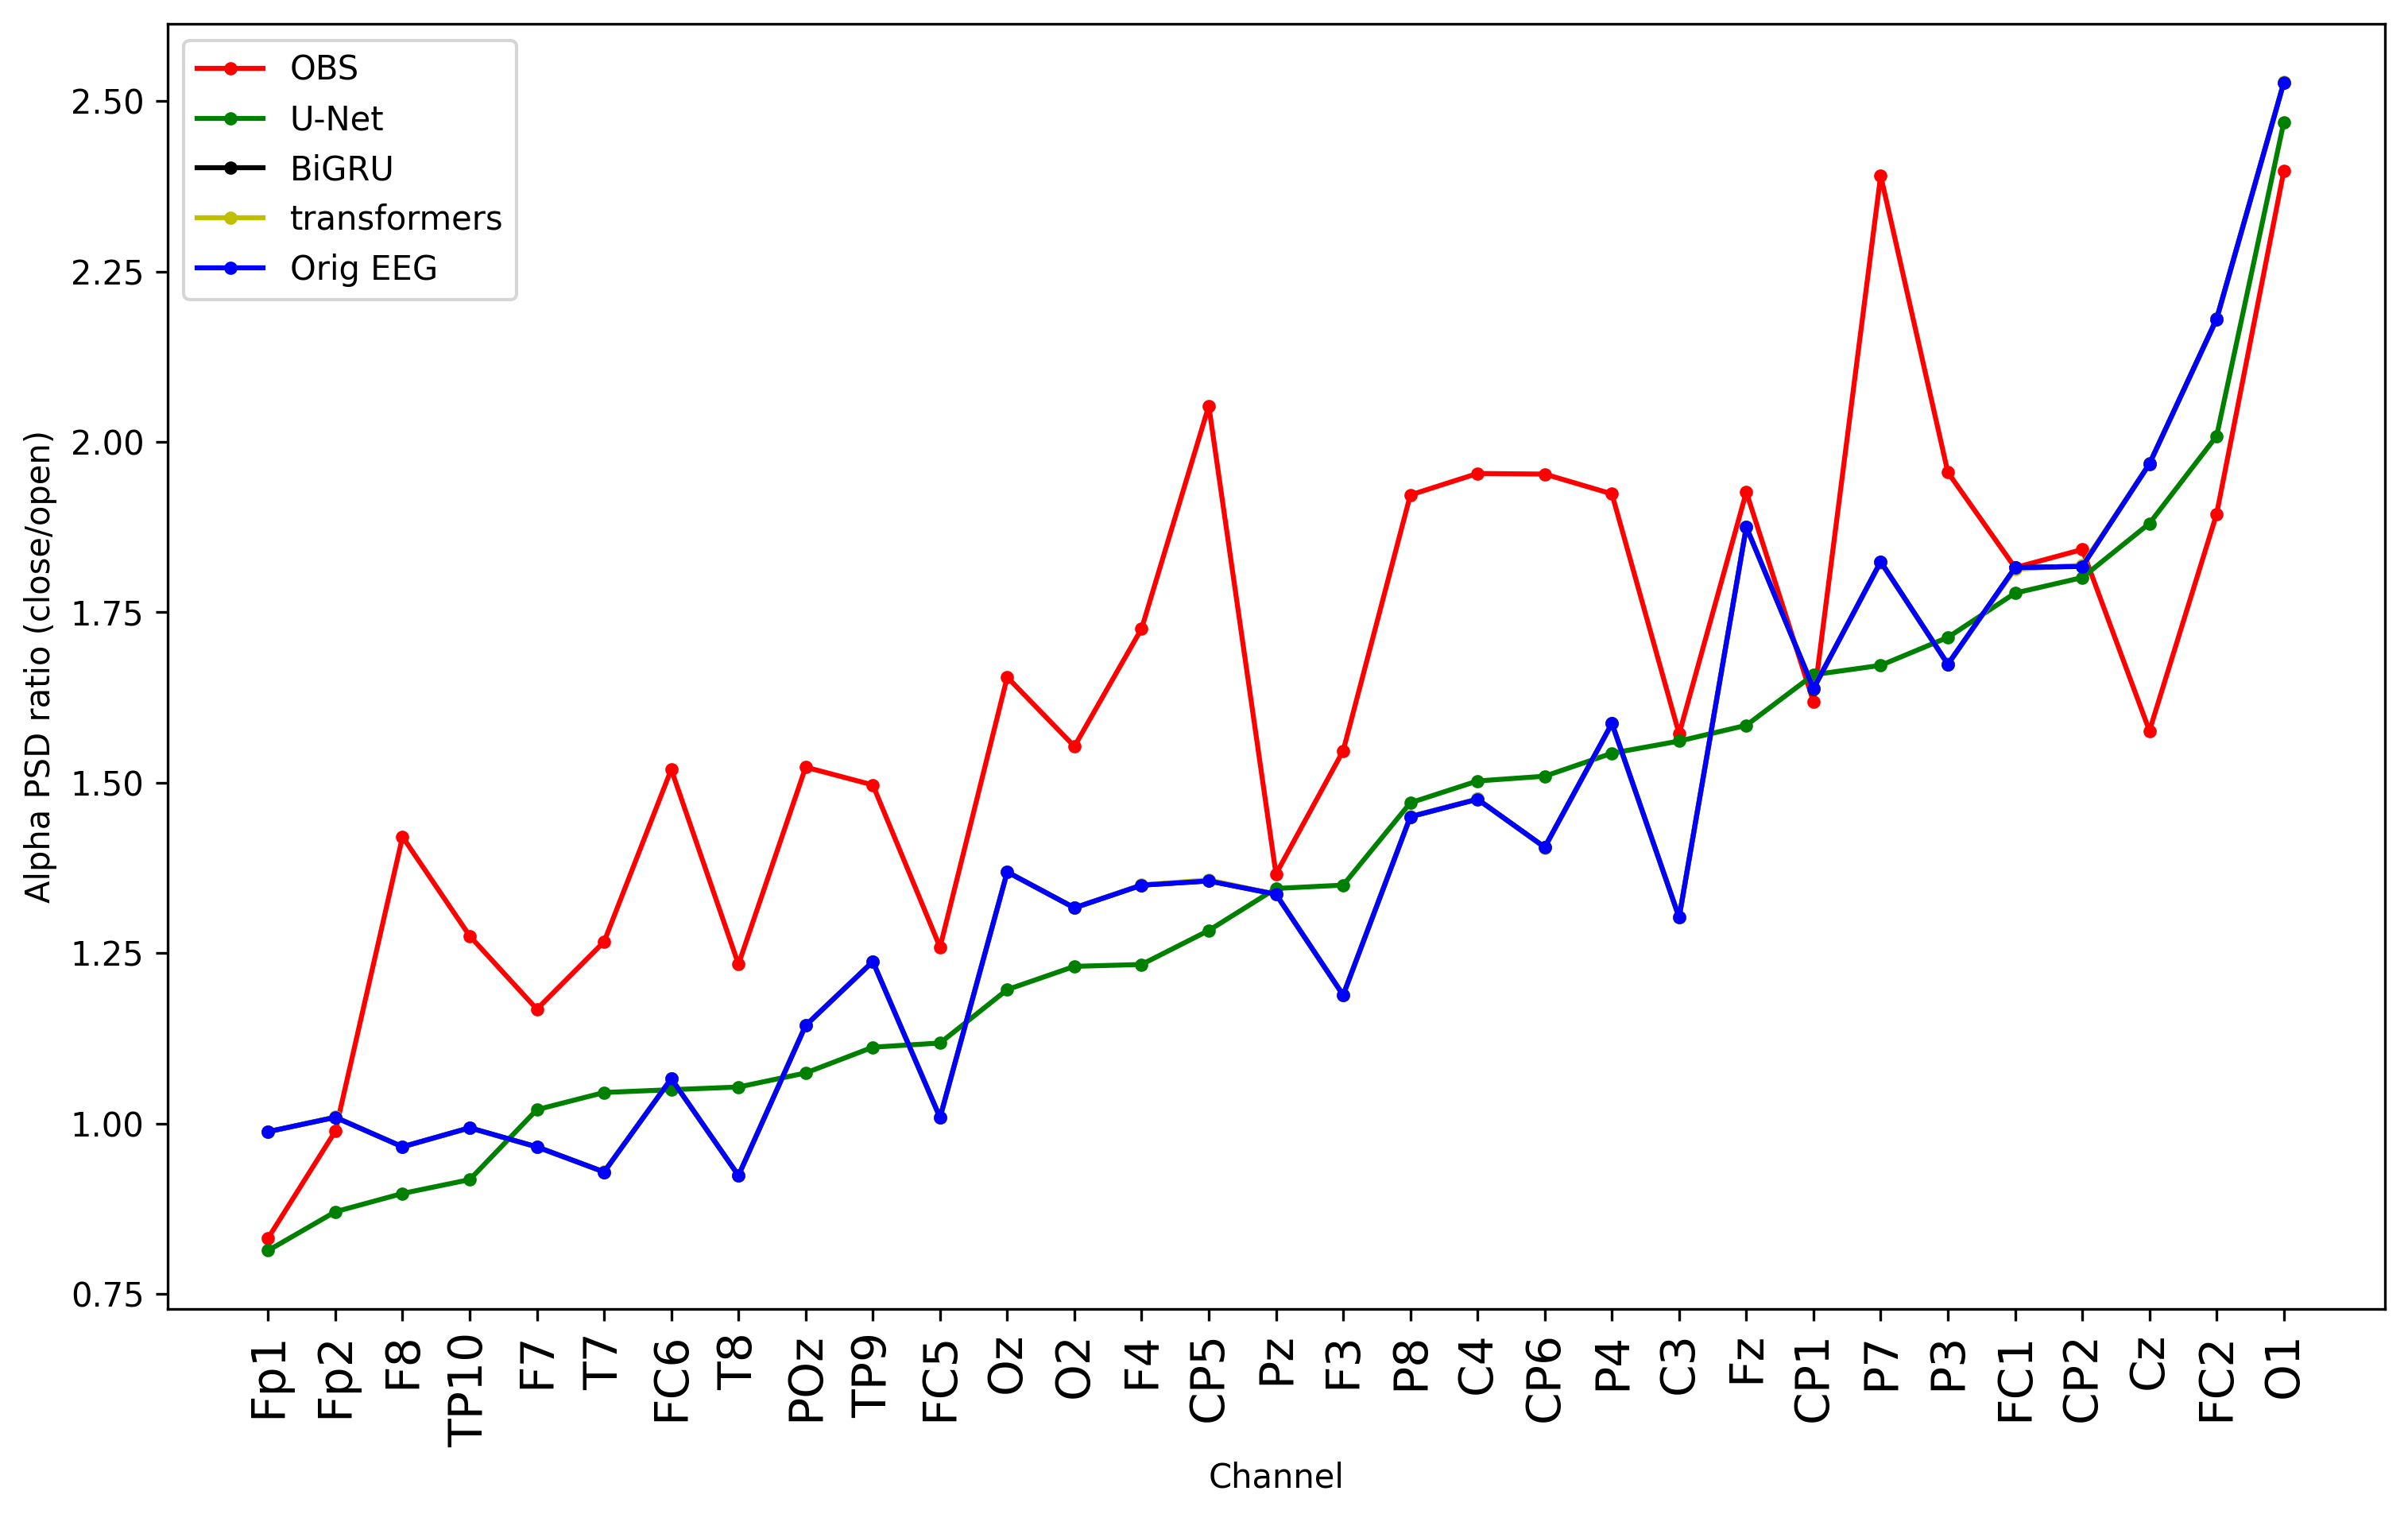

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7), dpi=300)
indx = np.argsort(np.mean(result_unet, axis=0).flatten())

plt.plot(np.mean(result_obs, axis=0)[indx], 'r.-', label='OBS')
plt.plot(np.mean(result_unet, axis=0)[indx] , 'g.-', label='U-Net')
plt.plot(np.mean(result_bigru, axis=0)[indx] , 'k.-', label='BiGRU')
plt.plot(np.mean(result_transformers, axis=0)[indx] , 'y.-', label='transformers')
plt.plot(np.mean(result_eeg, axis=0)[indx], 'b.-', label='Orig EEG')

label = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1',
         'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz',
         'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6',
         'CP5', 'CP6', 'TP9', 'TP10', 'POz']
label = [label[ii] for ii in indx]
plt.xlabel('Channel')
plt.ylabel('Alpha PSD ratio (close/open)')
plt.xticks(np.arange(31), label, fontsize=14, rotation=90)

plt.legend()